In [153]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t
from scipy.special import erf

#Custom functions
def load_bins(obj):
    #Load csv files
    bins = pd.read_csv('/Users/terwelj/Projects/Late-time_signals/version_test_results/'+obj+'/all_bins.csv', header=0)
    settings = pd.read_csv('/Users/terwelj/Projects/Late-time_signals/version_test_results/'+obj+'/settings.csv', index_col=0)
    try:
        tail_fit = pd.read_csv('/Users/terwelj/Projects/Late-time_signals/version_test_results/'+obj+'/tail_fits.csv', index_col=0)
    except:
        tail_fit = None

    #load lightcurve properly
    lc_points = pd.read_csv(settings.loc['obj_path'][0], header=0, usecols=['obsmjd', 'filter', 'Fratio', 'Fratio.err', 'mag', 'mag_err', 'upper_limit', 'data_hasnan'])
    lc_points.rename(columns={'filter':'obs_filter', 'Fratio.err':'Fratio_err'}, inplace=True)
    lc_points = lc_points[lc_points.data_hasnan==False]
    lc_g = lc_points[lc_points.obs_filter.str.contains('g')].reset_index(drop=True)
    lc_r = lc_points[lc_points.obs_filter.str.contains('r')].reset_index(drop=True)
    lc_i = lc_points[lc_points.obs_filter.str.contains('i')].reset_index(drop=True)
    return bins, settings, tail_fit, lc_g, lc_r, lc_i

def plot_bins(bins, settings, tail_fit, lc, zp, show_err=False, show_std=False, xlim=None, ylim=None):
    peak_mjd = float(settings.loc['peak_date'][0])
    late_time = float(settings.loc['late_time'][0])
    
    #Make the plot
    plt.figure(figsize=(12,8))
    plt.xlabel('days after peak at MJD {}'.format(peak_mjd), size=18)
    plt.ylabel(r'Flux (10$^{-16}$ erg/s/cm$^2$/$\AA$)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    #Plot the datapoints and bins
    plt.errorbar(lc[lc.obsmjd>peak_mjd+late_time].obsmjd-peak_mjd, lc[lc.obsmjd>peak_mjd+late_time].Fratio*zp,
        yerr=lc[lc.obsmjd>peak_mjd+late_time].Fratio_err*zp, fmt='.', color='r')
    plt.axhline(0, color='k')
    for i in range(len(bins)):
        plt.plot([bins.mjd_start.iloc[i]-peak_mjd, bins.mjd_stop.iloc[i]-peak_mjd], [bins.Fratio.iloc[i]*zp, bins.Fratio.iloc[i]*zp], 'b')
        if show_err:
            plt.fill_between([bins.mjd_start.iloc[i]-peak_mjd, bins.mjd_stop.iloc[i]-peak_mjd], [(bins.Fratio.iloc[i]+bins.Fratio_err.iloc[i])*zp, (bins.Fratio.iloc[i]+bins.Fratio_err.iloc[i])*zp],
                             [(bins.Fratio.iloc[i]-bins.Fratio_err.iloc[i])*zp, (bins.Fratio.iloc[i]-bins.Fratio_err.iloc[i])*zp], color='k', alpha=0.3)
        if show_std:
            plt.fill_between([bins.mjd_start.iloc[i]-peak_mjd, bins.mjd_stop.iloc[i]-peak_mjd], [(bins.Fratio.iloc[i]+bins.Fratio_std.iloc[i])*zp, (bins.Fratio.iloc[i]+bins.Fratio_std.iloc[i])*zp],
                             [(bins.Fratio.iloc[i]-bins.Fratio_std.iloc[i])*zp, (bins.Fratio.iloc[i]-bins.Fratio_std.iloc[i])*zp], color='b', alpha=0.3)
    plt.show()
    return

def model(x, a, b):
    #The model in mag space
    return a*x + b

def errors(x, Caa, Cab, Cba, Cbb, chi2red, dof, sigma):
    #Model error estimation in mag space
    tval = t.ppf((erf(sigma/np.sqrt(2)) + 1)/2, dof)
    dy = tval * np.sqrt(chi2red * (np.ones_like(x)*Cbb+x*(Cab+Cba)+x**2*Caa))
    return dy

def rm_tails(fit, lcs):
    fits = [fit.loc['ZTF_g'], fit.loc['ZTF_r'], fit.loc['ZTF_i']]
    for i in range(len(fits)):
        #Skip if no fit was done
        if fits[i].a == 0:
            continue
        indices = lcs[i][(lcs[i].obsmjd>fits[i].fit_start_mjd) & (lcs[i].obsmjd<fits[i].fit_end_mjd)].index
        mod_y = model(lcs[i].obsmjd.iloc[indices]-fits[i].fit_zero, fits[i].a, fits[i].b)
        mod_dy = errors(lcs[i].obsmjd.iloc[indices]-fits[i].fit_zero, fits[i].Caa, fits[i].Cab, fits[i].Cba, fits[i].Cbb, fits[i].chi2red, fits[i].dof, 1)
        mod_y = 10**(-mod_y/2.5)
        mod_dy = mod_y * np.log(10) * mod_dy / 2.5
        lcs[i].loc[indices, 'Fratio'] -= mod_y
        lcs[i].loc[indices, 'Fratio_err'] = np.sqrt(lcs[i].loc[indices, 'Fratio_err']**2 + mod_dy**2)
    return lcs

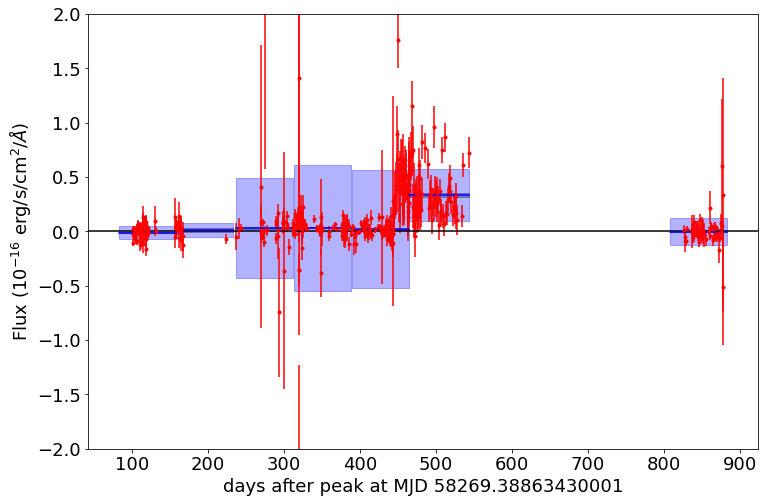

In [160]:
#Load object
bins, settings, tail_fit, lc_g, lc_r, lc_i = load_bins('ZTF18aasdted')

#Remove the fitted tail if it is there
if tail_fit is not None:
    [lc_g, lc_r, lc_i] = rm_tails(tail_fit, [lc_g, lc_r, lc_i])

#Choose what needs to be shown
obs_filter = 'ZTF_g'
binsize = 75
phase = 0.25

ylim=[-2,2]

#Zeropoints to convert to correct units
zpg = 4.880e7
zpr = 2.708e7
zpi = 4.880e7

#Select the correct bins & make the plot
selection = bins[(bins.obs_filter==obs_filter) & (bins.binsize==binsize) & (bins.phase==phase)]
plot_bins(selection, settings, tail_fit, lc_g, zpg, show_err=True, show_std=True, ylim=ylim)